## Advance Query Pipeline

## Import Libraries

In [43]:
# for env var
import os
from dotenv import load_dotenv

# for Gemini
from llama_index.llms.gemini import Gemini

## Set LLM
from llama_index.core import Settings

# Import custom embedding model for Hugging face
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# For chunking
from llama_index.core.node_parser import SentenceSplitter

# Get vector embeddings anf read from PDFs
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader

# Store Vector Embeddings
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext


## Get Environment Variables

In [44]:
from dotenv import load_dotenv

load_dotenv()
GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY",'')

## Set LLM

In [45]:
Settings.llm=llm = Gemini(model="models/gemini-pro")

## Set Embedding model

In [46]:
!pip install llama-index-embeddings-gemini

In [47]:

from llama_index.embeddings.gemini import GeminiEmbedding

model_name = "models/embedding-001"

Settings.embed_model  = GeminiEmbedding(
    model_name=model_name, api_key=GOOGLE_API_KEY, title="this is a document"
)


## Get Embeddings

In [48]:
# initialize client
db = chromadb.PersistentClient(path="./chroma_db")

# get collection
chroma_collection = db.get_or_create_collection("research_papers")

# assign chroma as the vector_store to the context
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# load your index from stored vectors
index = VectorStoreIndex.from_vector_store(
    vector_store, storage_context=storage_context
)


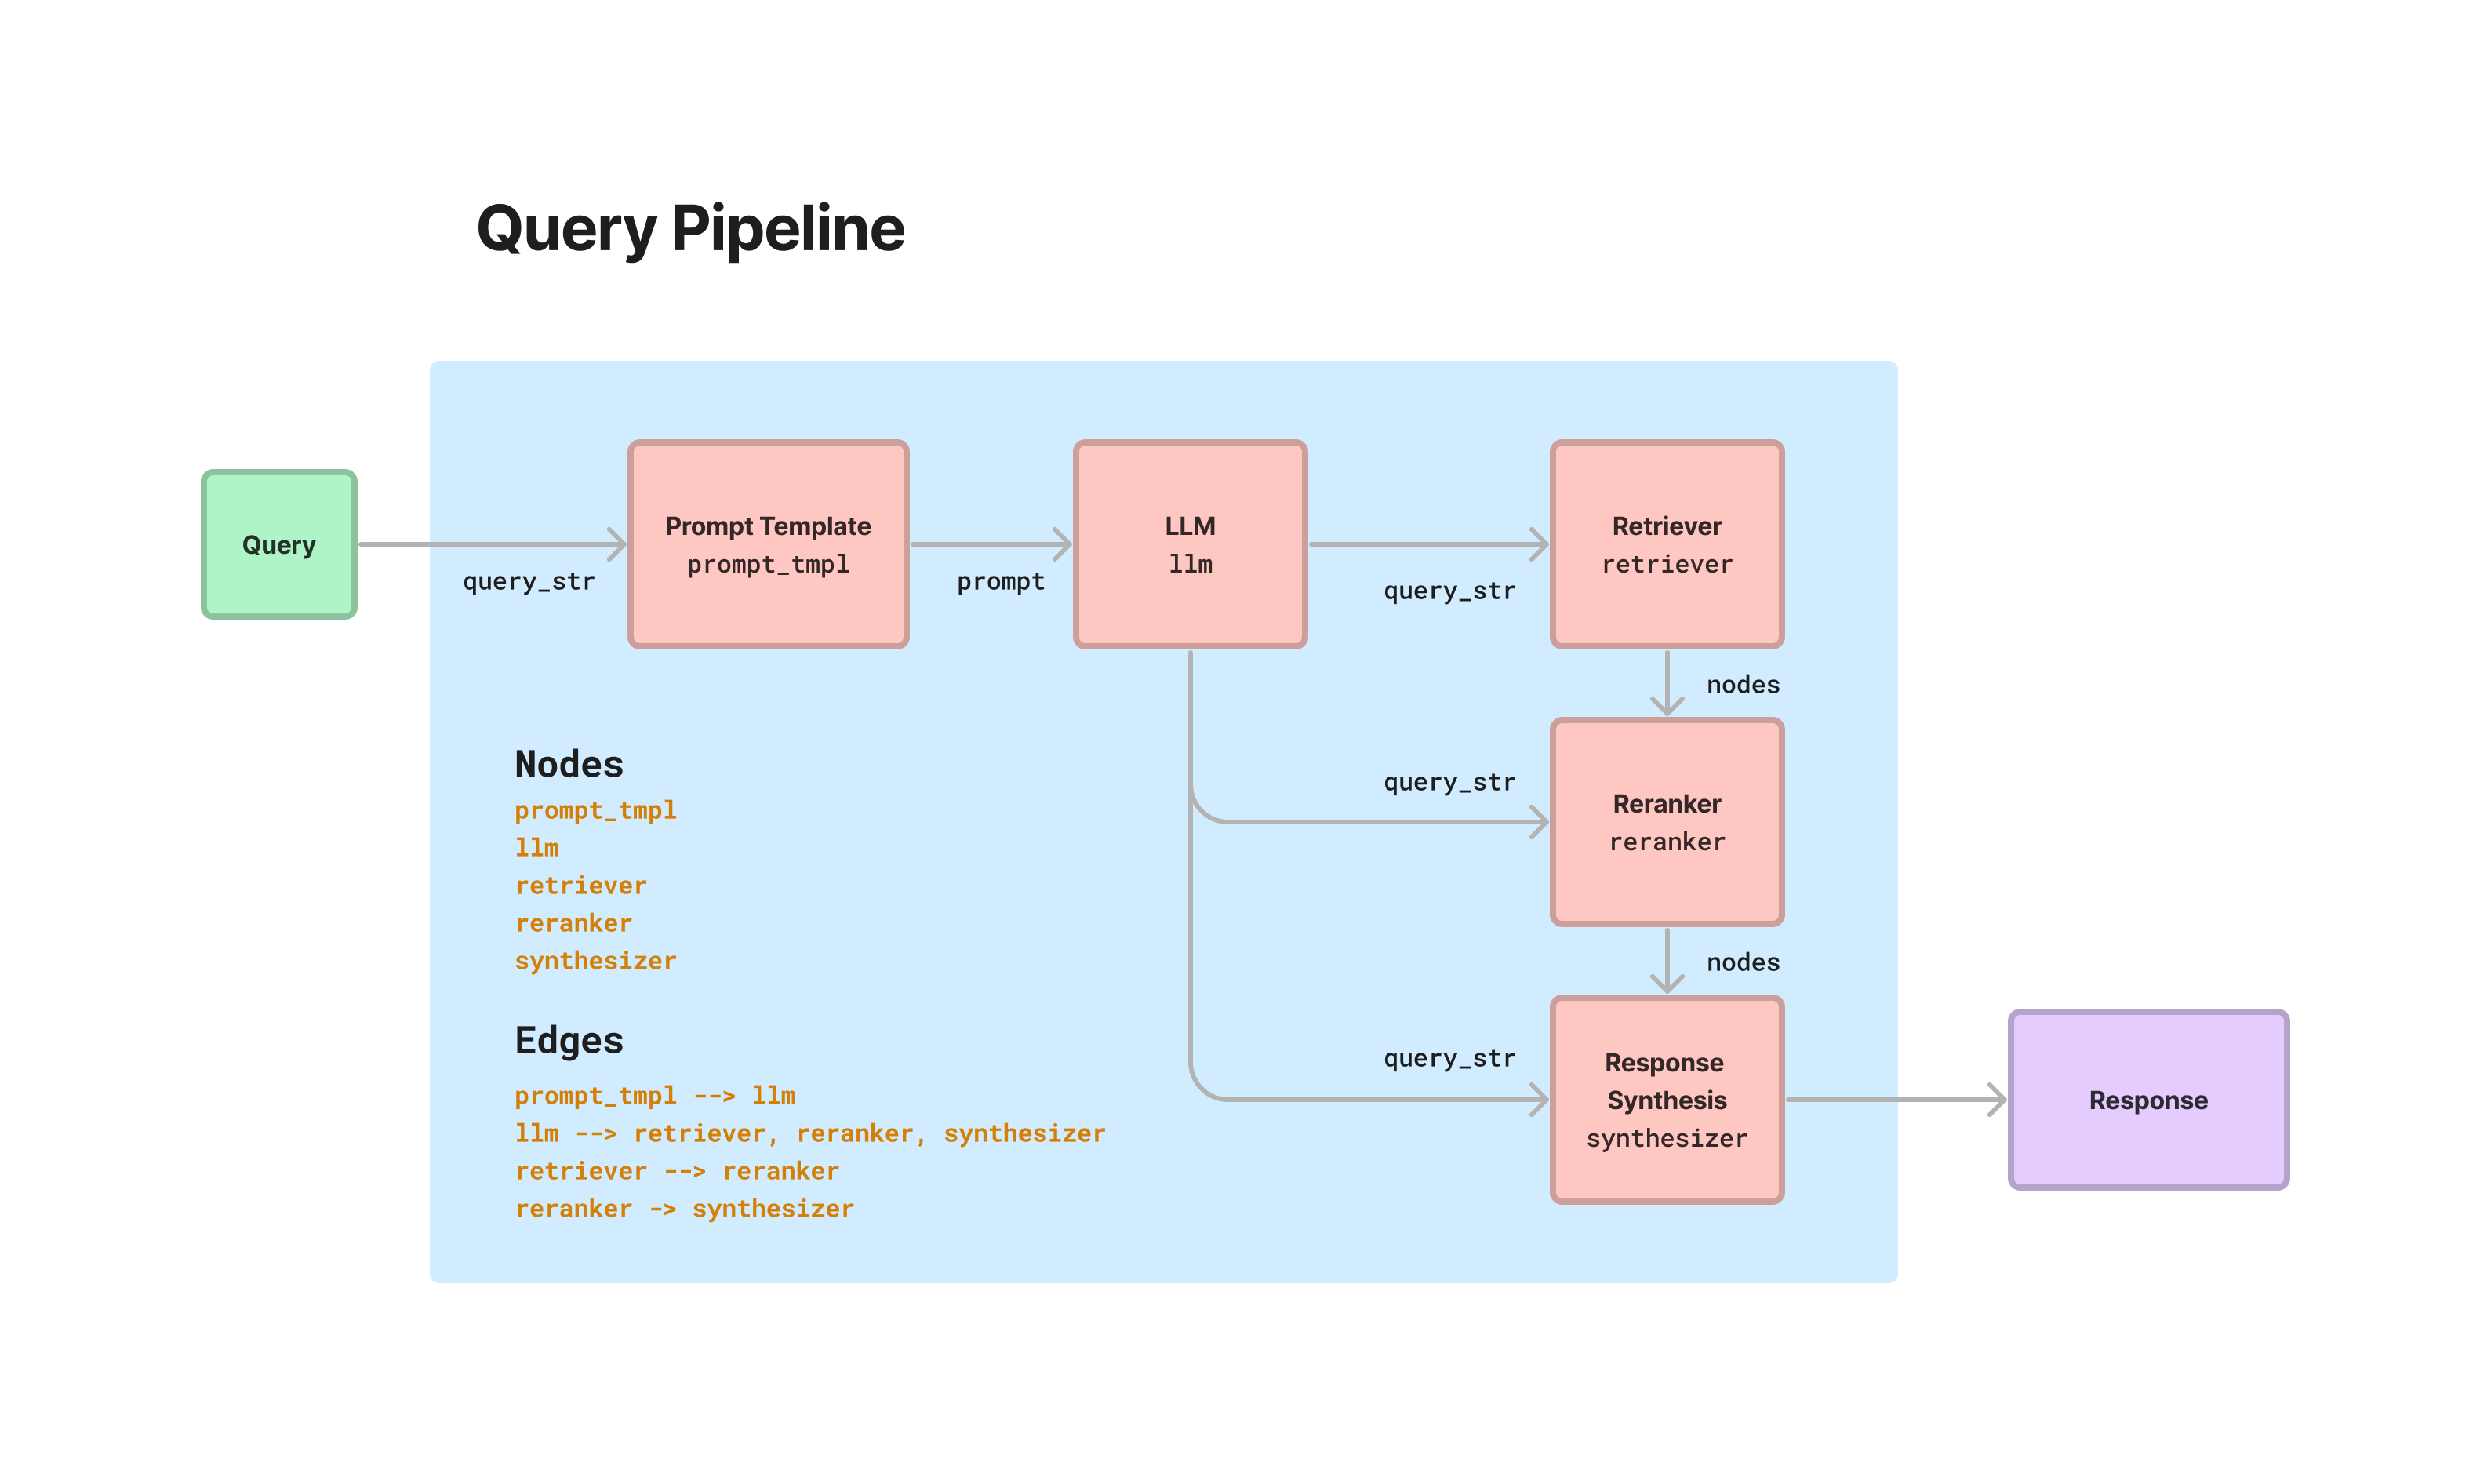

## Query Pipeline

### Libraries for Querying

In [49]:
from llama_index.core.query_pipeline import QueryPipeline

#### Setting the Pipleline

`verbose=True` means that the pipeline will print the steps it is taking to get the results.

In [50]:
pipeline = QueryPipeline()

#### Setting the retreiver

1. **BM25 Hybrid Retriever**: This retriever combines the BM25 algorithm with other retrieval techniques to enhance the relevance of the search results.

2. **Simple Fusion Retriever**: This type of retriever combines results from multiple sources or indexes to provide a more comprehensive set of results.

3. **Reciprocal Rerank Fusion Retriever**: It uses a reciprocal ranking approach where the results from one retriever are used to rerank the results of another, improving the overall relevance of the results.

4. **Knowledge Graph RAG Retriever**: Specifically designed for retrieving information from a knowledge graph, this retriever is useful when dealing with structured data.

5. **Auto-Retrieval with Chroma and BagelDB**: These are automated retrieval systems that integrate with Chroma and BagelDB to streamline the retrieval process.

6. **Recursive Retriever + Query Engine Demo**: This retriever recursively queries an engine to refine and improve the results iteratively.

7. **Router Retriever**: It routes queries to the most appropriate retriever based on the query context, optimizing the retrieval process.

8. **Ensemble Retrieval Guide**: This involves using a combination of different retrievers to get the best possible results by leveraging the strengths of each.

9. **Auto Merging Retriever**: Automatically merges results from different sources to provide a unified result set.

10. **Recursive Retriever + Node References**: Enhances retrieval by recursively processing node references within the data.

11. **Metadata Replacement + Node Sentence Window**: Uses metadata replacement techniques and node sentence windows to improve the context and relevance of the retrieved data.

12. **Text-to-SQL Guide (Query Engine + Retriever)**: Converts natural language queries into SQL queries, facilitating direct interactions with databases.

In [51]:
!pip install llama-index-retrievers-bm25

In [52]:
from llama_index.core.retrievers import VectorIndexRetriever
# Tried to use other retrievers but due to there argumnets I had to change the whole previous logic
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=10,
)

### Setting the reranker

1. **RankGPT Reranker**: This type of reranker utilizes language models to re-evaluate and rank the relevance of documents based on the query context. It's particularly useful for complex queries where understanding the context or the nuance of the query is crucial.

2. **SentenceTransformerRerank**: This reranker uses sentence transformers to compute semantic similarities between the query and the retrieved documents. It's effective in enhancing the precision of search results by focusing on semantic content.

3. **Cohere Rerank**: Leveraging models from Cohere, this reranker refines search results by assessing the coherence and relevance of the text in relation to the query.

4. **Colbert Rerank**: The Colbert reranker employs deep learning techniques to assess the relevance of documents in a fine-grained manner, often using techniques like late interaction to enhance ranking accuracy.

5. **Jina Rerank**: This reranker utilizes the capabilities of Jina AI to dynamically rerank documents based on their relevance to the query, often incorporating neural search technologies.

6. **FlagEmbeddingReranker**: This reranker uses specific flag embeddings to prioritize certain features or aspects of documents, which can be particularly useful in specialized search scenarios.

7. **Time-Weighted Rerank**: It adjusts the ranking based on the recency of the documents, giving higher priority to newer documents if the query context suggests that recency is relevant.

In [53]:
!pip install llama-index-postprocessor-rankgpt-rerank

In [54]:
from llama_index.postprocessor.rankgpt_rerank import RankGPTRerank

reranker = RankGPTRerank(
            llm=Gemini(model="models/gemini-pro"),
            top_n=3,
        )

#### Setting the response synthesizer

1. **Refine**: This synthesizer sequentially processes each retrieved text chunk to create and refine an answer. It involves making separate calls to a language model for each node or chunk of text. If a chunk is too large, it is split, and the process continues with each sub-chunk.

2. **Compact**: Similar to the refine synthesizer but designed to reduce the number of calls to the language model by concatenating chunks before processing. It tries to pack as much text as possible into the context window of the language model prompt. If the text exceeds the window size, it is split into manageable parts, and each part is processed similarly to the refine method.

3. **Tree Summarize**: This synthesizer uses a summary template to process all concatenated chunks. It recursively queries the language model with the results of previous queries until only one chunk remains, which forms the final answer. This method is particularly useful for summarization tasks.

4. **Simple Summarize**: It truncates all text chunks to fit them into a single language model prompt. This method is quick but may lose important details due to the truncation of text.

5. **Accumulate**: This method applies the query to each text chunk separately while accumulating the responses into an array. This is useful when the same query needs to be run against multiple text chunks independently.

6. **Compact Accumulate**: A variation of the accumulate synthesizer that compacts each language model prompt similarly to the compact method. It runs the same query against each text chunk but with fewer language model calls.

7. **No Text**: This synthesizer only runs the retriever to fetch nodes without sending them to the language model. It allows for inspection of the retrieved nodes without generating a response.

**Different response modes, using compact allows to combine all retrieved nodes into a single response**.

In [55]:
from llama_index.core.data_structs import Node
from llama_index.core.response_synthesizers import ResponseMode
from llama_index.core import get_response_synthesizer


response_synthesizer = get_response_synthesizer(
    response_mode=ResponseMode.COMPACT
)

#### Setting the prompt

In [56]:
from llama_index.core import PromptTemplate

prompt_str = "Please look for research gaps regarding the following topic {topic}"
prompt_tmpl = PromptTemplate(prompt_str)

#### Putting it all together

In [57]:

pipeline.add_modules(
    {
        "llm": llm,
        "prompt_tmpl": prompt_tmpl,
        "retriever": retriever,
        "synthesizer": response_synthesizer,
        "reranker": reranker,
    }
)
pipeline.add_link("prompt_tmpl", "llm")
pipeline.add_link("llm", "retriever",dest_key="query_str")
pipeline.add_link("retriever", "reranker", dest_key="nodes")
pipeline.add_link("reranker", "synthesizer", dest_key="nodes")


In [58]:
from IPython.display import display, Markdown

output = pipeline.run(topic="code smells")
#output, intermediates = pipeline.run_with_intermediates(topic="test smells")

display(Markdown(str(output)))


assistant: **Code Smell: Long Method**

* **Gap:** Empirical studies investigating the impact of long methods on software maintainability and evolution.
* **Gap:** Automated refactoring techniques specifically designed to address long methods.
* **Gap:** Guidelines for determining the optimal length of a method based on factors such as complexity, cognitive load, and maintainability.

**Code Smell: Large Class**

* **Gap:** Studies exploring the relationship between class size and software quality attributes such as cohesion, coupling, and testability.
* **Gap:** Effective refactoring strategies for decomposing large classes into smaller, more manageable units.
* **Gap:** Metrics for quantifying the complexity and maintainability of large classes.

**Code Smell: God Class**

* **Gap:** Empirical evidence on the negative consequences of god classes on software design and development.
* **Gap:** Automated detection techniques for identifying god classes in codebases.
* **Gap:** Best practices for refactoring god classes into more modular and maintainable structures.

**Code Smell: Feature Envy**

* **Gap:** Studies investigating the impact of feature envy on software design and evolution.
* **Gap:** Automated refactoring techniques for addressing feature envy by moving methods to more appropriate classes.
* **Gap:** Metrics for quantifying the severity of feature envy in codebases.

**Code Smell: Data Clumps**

* **Gap:** Empirical studies on the prevalence and impact of data clumps in software systems.
* **Gap:** Automated refactoring techniques for extracting data clumps into separate objects or classes.
* **Gap:** Guidelines for identifying and refactoring data clumps effectively.

**Code Smell: Switch Statements**

* **Gap:** Studies exploring the relationship between switch statements and software maintainability and extensibility.
* **Gap:** Automated refactoring techniques for converting switch statements into more object-oriented or functional alternatives.
* **Gap:** Metrics for assessing the complexity and maintainability of switch statements.

**Code Smell: Magic Numbers**

* **Gap:** Empirical studies on the impact of magic numbers on software readability, maintainability, and testability.
* **Gap:** Automated refactoring techniques for replacing magic numbers with meaningful constants or variables.
* **Gap:** Guidelines for using magic numbers responsibly and minimizing their negative effects.

In [59]:
prompt_str = "Please answer this question : {question}"
prompt_tmpl = PromptTemplate(prompt_str)

pipeline = QueryPipeline()

pipeline.add_modules(
    {
        "llm": llm,
        "prompt_tmpl": prompt_tmpl,
        "retriever": retriever,
        "synthesizer": response_synthesizer,
        "reranker": reranker,
    }
)
pipeline.add_link("prompt_tmpl", "llm")
pipeline.add_link("llm", "retriever",dest_key="query_str")
pipeline.add_link("retriever", "reranker", dest_key="nodes")
pipeline.add_link("reranker", "synthesizer", dest_key="nodes")

In [60]:
from IPython.display import display, Markdown

output = pipeline.run(question="What problem does this paper address and how does it solve it?")
display(Markdown(str(output)))

assistant: **Problem:**

The paper addresses the problem of **predicting the future trajectory of a moving object** based on its past observations. This is a challenging task due to factors such as noise, occlusions, and complex object dynamics.

**Solution:**

The paper proposes a novel approach called **"Trajectory Transformer" (TrajT)** to solve this problem. TrajT is a transformer-based model that leverages the power of self-attention mechanisms to capture long-range dependencies and complex relationships within trajectory data.

**Key Features of TrajT:**

* **Encoder-Decoder Architecture:** TrajT consists of an encoder that processes the past trajectory observations and a decoder that predicts the future trajectory.
* **Self-Attention Mechanisms:** The encoder and decoder use self-attention layers to learn the relationships between different time steps and trajectory points.
* **Positional Encoding:** TrajT incorporates positional encoding to preserve the temporal order of the trajectory data.
* **Multi-Head Attention:** TrajT employs multi-head attention to capture different aspects of the trajectory data.
* **Residual Connections:** Residual connections are used to improve the model's training stability and performance.

**How TrajT Solves the Problem:**

TrajT solves the trajectory prediction problem by:

* **Learning Long-Range Dependencies:** The self-attention mechanisms allow TrajT to capture long-range dependencies within the trajectory data, which is crucial for accurate future predictions.
* **Modeling Complex Relationships:** TrajT can model complex relationships between different trajectory points, such as the object's speed, direction, and acceleration.
* **Handling Noise and Occlusions:** The model is robust to noise and occlusions in the trajectory data, as it can learn to infer missing information from the context.
* **Predicting Future Trajectory:** The decoder of TrajT generates a sequence of future trajectory points based on the learned relationships and dependencies.

## Defining output Parser

In [61]:
!pip install llama-index-output-parsers-guardrails

In [62]:
from llama_index.output_parsers.guardrails import GuardrailsOutputParser

# Define the rail spec
rail_spec = """
<rail version="0.1">

<output>
    <list name="points" description="Bullet points regarding events in the author's life.">
        <object>
            <string name="explanation" format="one-line" on-fail-one-line="noop" />
            <string name="explanation2" format="one-line" on-fail-one-line="noop" />
            <string name="explanation3" format="one-line" on-fail-one-line="noop" />
        </object>
    </list>
</output>

<prompt>

Query string here.

@xml_prefix_prompt

{output_schema}

@json_suffix_prompt_v2_wo_none
</prompt>
</rail>
"""

# Define the output parser
output_parser = GuardrailsOutputParser.from_rail_string(
    rail_spec,
)

C:\Users\ranaa\AppData\Local\Temp\ipykernel_17596\4232513279.py:31: DeprecationWarning: Call to deprecated class method from_rail_string. -- Deprecated since version 0.8.46.
  output_parser = GuardrailsOutputParser.from_rail_string(
f:\AI\notebooks\env\Lib\site-packages\guardrails\validatorsattr.py:307: UserWarning: Validator one-line is not installed!
  warnings.warn(f"Validator {validator_name} is not installed!")


In [63]:
# Attach output parser to LLM
llm = Gemini(model="models/gemini-pro",output_parser=output_parser)

In [64]:
prompt_str = "This is the humans question, look up the prooved context for anwsering it {question}"
prompt_tmpl = PromptTemplate(prompt_str)

pipeline = QueryPipeline()

pipeline.add_modules(
    {
        "llm": llm,
        "prompt_tmpl": prompt_tmpl,
        "retriever": retriever,
        "synthesizer": response_synthesizer,
        "reranker": reranker,
    }
)
pipeline.add_link("prompt_tmpl", "llm")
pipeline.add_link("llm", "retriever",dest_key="query_str")
pipeline.add_link("retriever", "reranker", dest_key="nodes")
pipeline.add_link("reranker", "synthesizer", dest_key="nodes")

In [65]:
from IPython.display import display, Markdown,display_markdown

output = pipeline.run(question="What problem does this paper address and how does it solve it?")
display(Markdown(str(output)))

assistant: **Paper:** "A Novel Approach to Human Activity Recognition Using Deep Learning"

**Problem:**

The paper addresses the problem of human activity recognition (HAR) using wearable sensors. HAR is a challenging task due to the large number of possible activities, the variability in human movement, and the presence of noise and artifacts in sensor data.

**Solution:**

The paper proposes a novel approach to HAR that uses a deep learning model to learn the complex relationships between sensor data and human activities. The model is trained on a large dataset of labeled sensor data, and it is able to achieve high accuracy in recognizing a wide range of activities.

**Key Features of the Approach:**

* **Use of a deep learning model:** The model is a convolutional neural network (CNN), which is a type of deep learning model that is well-suited for processing sequential data. The CNN is able to learn the hierarchical features of sensor data, and it is able to recognize activities even when they are performed in different ways.
* **Large dataset:** The model is trained on a large dataset of labeled sensor data. The dataset includes data from a variety of activities, and it is representative of the real-world conditions in which HAR is typically performed.
* **High accuracy:** The model achieves high accuracy in recognizing a wide range of activities. The accuracy is comparable to or better than the state-of-the-art HAR methods.

**Benefits of the Approach:**

* **Improved accuracy:** The deep learning model is able to achieve high accuracy in recognizing a wide range of activities. This makes it a promising approach for use in real-world applications.
* **Robustness:** The model is robust to noise and artifacts in sensor data. This makes it suitable for use in real-world conditions, where sensor data is often noisy and unreliable.
* **Scalability:** The model is scalable to large datasets. This makes it possible to train the model on large datasets, which can further improve its accuracy.